In [1]:
import os
import time
import numpy as np
from PIL import Image
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from torchvision import transforms
from torchvision import models
import torch
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
from numpy import printoptions
import requests
import tarfile
import random
import json
import torch.optim as optim

c:\Users\NGN\anaconda3\envs\auto_tagging\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Fix all seeds to make experiments reproducible
torch.manual_seed(2024)
torch.cuda.manual_seed(2024)
np.random.seed(2024)
random.seed(2024)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [4]:
# Simple dataloader and label binarization, 
# that is converting test labels into binary arrays of length 6
# (number of classes) with 1 in places of applicable labels).
class MpstDataset(Dataset):
    def __init__(self, data_path, anno_path, transforms, split_type):
        self.transforms = transforms
        self.split_type= split_type
        with open(anno_path) as fp:
            json_data = json.load(fp)
        samples = json_data['samples']
        self.classes = json_data['labels']

        self.imgs = [] # 이미지 이름
        self.annos = [] # 태그 이름
        self.annos_idx = []
        self.data_path = data_path
        print('loading', anno_path)
        for sample in samples:
            if(sample['genre'])=='Action':
                label=0
            elif(sample['genre'])=='Comedy':
                label=1
            elif(sample['genre'])=='Crime':
                label=2 
            elif(sample['genre'])=='Drama':
                label=3
            elif(sample['genre'])=='Horror':
                label=4    
            elif(sample['genre'])=='Romance':
                label=5                                       
            self.imgs.append(sample['id'])
            self.annos.append(sample['genre'])
            self.annos_idx.append(label)
        for item_id in range(len(self.annos)):
            item = self.annos[item_id]
            vector = [cls in item for cls in self.classes]
            self.annos[item_id] = np.array(vector, dtype=float) # labeling one-hot encoding

    def __getitem__(self, item):
        anno = self.annos[item] 
        anno_idx = self.annos_idx[item]   
        img_path = os.path.join(self.data_path, self.split_type, self.imgs[item])
        img_path += '.png'
        img = Image.open(img_path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img, anno, anno_idx
    

    def __len__(self):
        return len(self.imgs)

In [5]:
import yaml
with open('./config/cfg.yaml') as f:
    cfg = yaml.safe_load(f)
    
img_folder = cfg['gr_img']['path']
split_train='train'
split_val='val'
dataset_train = MpstDataset(img_folder, os.path.join(img_folder, 'train', 'train.json'), None, split_train)
dataset_val = MpstDataset(img_folder, os.path.join(img_folder, 'val', 'val.json'), None, split_val)
print(f"train dataset len: {len(dataset_train)}")
print(f"val dataset len: {len(dataset_val)}")

# # A simple function for visualization.
# def show_sample(img, binary_img_labels):
#     # Convert the binary labels back to the text representation.    
#     img_labels = np.array(dataset_val.classes)[np.argwhere(binary_img_labels > 0)[:, 0]]
#     plt.imshow(img)
#     plt.title("{}".format(', '.join(img_labels)))
#     plt.axis('off')
#     plt.show()

# for sample_id in range(5):
#     show_sample(*dataset_val[sample_id])

loading E:\NRF_2022\MDPI\Extracted_Data\genre_972_split\train\train.json
loading E:\NRF_2022\MDPI\Extracted_Data\genre_972_split\val\val.json
train dataset len: 680
val dataset len: 146


Label Tag Distribution (count, class name): [(47, 'Romance'), (98, 'Crime'), (99, 'Horror'), (176, 'Action'), (197, 'Comedy'), (208, 'Drama')]


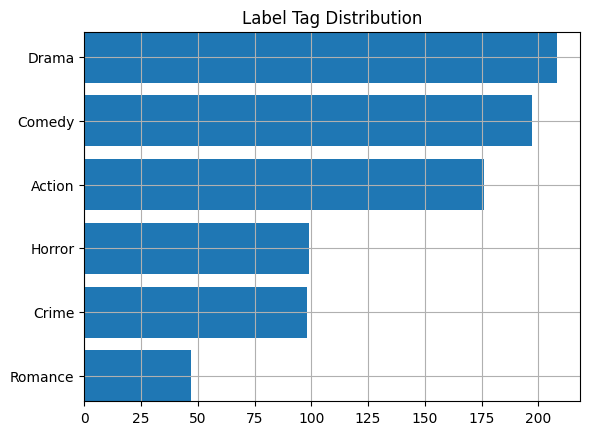

In [6]:
# Calculate label distribution for the entire dataset (train + val)
samples = dataset_val.annos + dataset_train.annos
samples = np.array(samples)
with printoptions(precision=3, suppress=True):
    class_counts = np.sum(samples, axis=0)
    # Sort labels according to their frequency in the dataset.
    sorted_ids = np.array([i[0] for i in sorted(enumerate(class_counts), key=lambda x: x[1])], dtype=int)
    print('Label Tag Distribution (count, class name):', list(zip(class_counts[sorted_ids].astype(int), np.array(dataset_val.classes)[sorted_ids])))
    # plt.barh(range(len(dataset_val.classes)), width=class_counts[sorted_ids])
    plt.barh(range(len(dataset_val.classes)), width=class_counts[sorted_ids])
    plt.yticks(range(len(dataset_val.classes)), np.array(dataset_val.classes)[sorted_ids])
    plt.gca().margins(y=0)
    plt.grid()
    plt.title('Label Tag Distribution')
    plt.show()

In [7]:
# Initialize the training parameters.
num_workers = 0 # 8 # Number of CPU processes for data preprocessing
lr = 1e-4 # Learning rate
batch_size = 6
save_freq = 1 # Save checkpoint frequency (epochs)
max_epoch_number = 100 # Number of epochs for training 

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [8]:
# Save path for checkpoints
save_path = './ckpt_genre/test1_3'
# Save path for logs
logdir = './logs_genre/test1_3'

# Run tensorboard
%load_ext tensorboard
%tensorboard --logdir {logdir}

In [9]:
def checkpoint_save(model, save_path, epoch):
    f = os.path.join(save_path, 'checkpoint-{:06d}.pth'.format(epoch)) # checkpoint-000000.pth
    if 'module' in dir(model):
        torch.save(model.module.state_dict(), f)
    else:
        torch.save(model.state_dict(), f)
    print('saved checkpoint:', f)

In [10]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:

img_folder=cfg['gr_img']['path']
split_train='train'
split_val='val'

# Initialize the dataloaders for training.
val_annotations = os.path.join(img_folder, 'val', 'val.json')
train_annotations = os.path.join(img_folder, 'train','train.json')

val_dataset = MpstDataset(img_folder, val_annotations, transforms_val, split_val)
train_dataset = MpstDataset(img_folder, train_annotations, transforms_train, split_train)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                              # drop_last=True
                              )
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

num_train_batches = int(np.ceil(len(train_dataset) / batch_size))
num_val_batches = int(np.ceil(len(val_dataset) / batch_size))
print(f"num_train_batches: {num_train_batches}")
print(f"num_val_batches: {num_val_batches}")

loading E:\NRF_2022\MDPI\Extracted_Data\genre_972_split\val\val.json
loading E:\NRF_2022\MDPI\Extracted_Data\genre_972_split\train\train.json
num_train_batches: 114
num_val_batches: 25


In [12]:
n1=0
# batch load
iterator = iter(val_loader)

# batch print
inputs, classes, c_idx = next(iterator)
print(inputs)
print(classes)
print(c_idx)

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-1.5185, -0.6281, -0.1828,  ...,  0.6049,  1.3070,  1.1529],
          [-1.8782, -1.7583, -1.5528,  ...,  0.6049,  0.8104, -0.0458],
          [-1.8782, -1.7583, -1.5528,  ...,  0.6049,  0.8104, -0.0458]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-1.2829,  1.5882,  2.0609,  ...,  2.2360,  1.8508,  2.2885],
          [-1.1779,  1.2556,  1.6232,  ...,  2.4286,  2.4286,  2.4286],
          [-1.1779,  1.2556,  1.6232,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 0.4265,  0.4265,  0.4265,  ...,  0.4265,  0.4265,  0.4265],
          [ 0.4265,  0.4265,  

In [13]:
# model = models.vgg19(pretrained=True)
# print(model)
# num_features = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_features, 6)
# model = model.to(device)
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)
# model = models.mobilenet_v2(pretrained=True)
# num_features = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(num_features, 6)
# model = model.to(device)
# output_=model(inputs.to(device))
# print(output_)
# _, preds = torch.max(output_, 1)
# print(preds)
# print(c_idx)
# print(preds==c_idx.to(device))

c:\Users\NGN\anaconda3\envs\auto_tagging\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\NGN\anaconda3\envs\auto_tagging\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
import copy

def train(model, optimizer, train_loader, val_loader,  
          device, logger):
    model.to(device)
 
    criterion = nn.CrossEntropyLoss()
    best_val_loss = 100.0
    best_val_acc = 0.0
    
    best_acc_model = None
    best_loss_model = None
    final_model = None
    
    iteration = 0
    best_loss_epoch = 0 

    start_time = time.time()
    for epoch in range(1, max_epoch_number+1):
        
        if epoch==1:
            best_loss_model = copy.deepcopy(model)
            final_model = copy.deepcopy(model)  
            
        running_corrects = 0
        model.train()
        train_loss = []
        
        for imgs, labels, lb_idx in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            lb_idx = lb_idx.to(device)
            # print(f"labels: {labels}")
            optimizer.zero_grad()
            output = model(imgs)
            _, preds = torch.max(output, 1)
            loss = criterion(output, labels.type(torch.float))
            batch_loss_value = loss.item()
            loss.backward()
            optimizer.step()
            running_corrects += torch.sum(preds == lb_idx)
            # tensorboard-1 
            logger.add_scalar('train_loss/iter', batch_loss_value, iteration) # train_loss per iter
            train_loss.append(batch_loss_value) # 
            iteration+=1
            
        # validation per epoch           
        _val_loss  = validation(model, criterion, val_loader, device, logger, iteration)
        epoch_acc = running_corrects / len(train_dataset) * 100.
        
        if _val_loss < best_val_loss: # best_loss model save
            best_val_loss = _val_loss
            best_loss_model = copy.deepcopy(model)
            best_loss_epoch = epoch
            checkpoint_save(best_loss_model, save_path, best_loss_epoch)
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc 
            best_acc_model = copy.deepcopy(model)
            best_acc_epoch=epoch
            checkpoint_save(best_acc_model, save_path, best_acc_epoch)
            
       # tensorboard-2: val_loss/epoch
        logger.add_scalar('val_loss/epoch' ,  _val_loss, epoch)
        _train_loss = np.mean(train_loss)
        # tensorboard-3: val_loss/iter
        logger.add_scalar('_train_loss/iter', _train_loss, iteration) 
        # tensorboard-4: val_loss/epoch
        logger.add_scalar('_train_loss/epoch', _train_loss, epoch) 
        
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] ')
        print(' Acc: {:.4f}% Time: {:.4f}s'.format( epoch_acc, time.time() - start_time))
        final_model=model
        
    return final_model, epoch,  best_loss_model, best_loss_epoch, best_acc_model, best_acc_epoch

def validation(model, criterion, val_loader, device, logger, iteration):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for imgs, labels, lb_idx in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            lb_idx = lb_idx.to(device)
            probs = model(imgs)
            loss = criterion(probs, labels.type(torch.float)) # BCE loss
            val_loss.append(loss.item())
        _val_loss = np.mean(val_loss) # val_loader loss per batch
    
    return _val_loss

In [16]:
print(logdir)
# Tensoboard logger
logger = SummaryWriter(logdir)
print(save_path)

./logs_genre/test1_3
./ckpt_genre/test1_3


In [17]:
# Initialize the model
# model = models.resnet34(pretrained=True)
# model = models.mobilenet_v2(pretrained=True)
# num_features = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(num_features, 6)
# num_features = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_features, 6)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)

In [ ]:
genre_ckpt_path=cfg['genre_ckpt']['path']
print(genre_ckpt_path)
load_dir = genre_ckpt_path + '\\test1_2\\checkpoint-000002.pth'
print(load_dir)

In [ ]:
# 저장된 ckpt를 불러와서 inference를 수행하는 경우
test_model = model
test_model = test_model.to(device)

test_model.load_state_dict(torch.load(load_dir ))

test_model.eval()

In [18]:
# Switch model to the training mode and move it to GPU.
model.train()

# If more than one GPU is available we can use both to speed up the training.
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [19]:
os.makedirs(save_path, exist_ok=True)

In [20]:
final_model, epoch, best_loss_model, best_loss_epoch, best_acc_model, best_acc_epoch \
= train(model, optimizer, train_loader, val_loader, 
        device, logger=logger)

100%|██████████| 25/25 [00:01<00:00, 17.54it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000001.pth
saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000001.pth
Epoch [1], Train Loss : [1.92213] Val Loss : [2.13326] 
 Acc: 24.4118% Time: 15.7860s


100%|██████████| 25/25 [00:01<00:00, 14.89it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000002.pth
Epoch [2], Train Loss : [1.76835] Val Loss : [2.21832] 
 Acc: 30.8824% Time: 28.8750s


100%|██████████| 25/25 [00:01<00:00, 15.37it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000003.pth
saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000003.pth
Epoch [3], Train Loss : [1.42133] Val Loss : [1.88254] 
 Acc: 42.6471% Time: 42.2260s


100%|██████████| 25/25 [00:01<00:00, 15.80it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000004.pth
Epoch [4], Train Loss : [1.31241] Val Loss : [1.94335] 
 Acc: 52.6471% Time: 55.4040s


100%|██████████| 25/25 [00:01<00:00, 17.32it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000005.pth
Epoch [5], Train Loss : [1.01594] Val Loss : [2.33790] 
 Acc: 61.4706% Time: 68.3870s


100%|██████████| 25/25 [00:01<00:00, 17.12it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000006.pth
Epoch [6], Train Loss : [0.66472] Val Loss : [3.11175] 
 Acc: 76.4706% Time: 81.3620s


100%|██████████| 25/25 [00:01<00:00, 17.32it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000007.pth
Epoch [7], Train Loss : [0.62409] Val Loss : [2.27416] 
 Acc: 78.3824% Time: 94.3240s


100%|██████████| 25/25 [00:01<00:00, 16.17it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000008.pth
Epoch [8], Train Loss : [0.49165] Val Loss : [2.92017] 
 Acc: 83.0882% Time: 107.4630s


100%|██████████| 25/25 [00:01<00:00, 17.68it/s]


Epoch [9], Train Loss : [0.54513] Val Loss : [2.84388] 
 Acc: 80.7353% Time: 120.3600s


100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000010.pth
Epoch [10], Train Loss : [0.37485] Val Loss : [2.79211] 
 Acc: 87.9412% Time: 133.3490s


100%|██████████| 25/25 [00:01<00:00, 16.74it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000011.pth
Epoch [11], Train Loss : [0.28901] Val Loss : [3.47047] 
 Acc: 89.4118% Time: 146.2810s


100%|██████████| 25/25 [00:01<00:00, 19.04it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000012.pth
Epoch [12], Train Loss : [0.30092] Val Loss : [2.79260] 
 Acc: 90.4412% Time: 159.3340s


100%|██████████| 25/25 [00:01<00:00, 18.98it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000013.pth
Epoch [13], Train Loss : [0.25994] Val Loss : [2.96574] 
 Acc: 90.7353% Time: 171.7020s


100%|██████████| 25/25 [00:01<00:00, 18.30it/s]


Epoch [14], Train Loss : [0.29120] Val Loss : [2.88969] 
 Acc: 89.5588% Time: 183.7250s


100%|██████████| 25/25 [00:01<00:00, 18.87it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000015.pth
Epoch [15], Train Loss : [0.18845] Val Loss : [2.79630] 
 Acc: 93.0882% Time: 195.8290s


100%|██████████| 25/25 [00:01<00:00, 18.88it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000016.pth
Epoch [16], Train Loss : [0.19010] Val Loss : [3.43733] 
 Acc: 93.5294% Time: 207.9810s


100%|██████████| 25/25 [00:01<00:00, 19.04it/s]


Epoch [17], Train Loss : [0.21486] Val Loss : [2.99687] 
 Acc: 92.9412% Time: 219.8800s


100%|██████████| 25/25 [00:01<00:00, 18.60it/s]


Epoch [18], Train Loss : [0.26361] Val Loss : [2.55006] 
 Acc: 90.1471% Time: 231.8080s


100%|██████████| 25/25 [00:01<00:00, 17.96it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000019.pth
Epoch [19], Train Loss : [0.09830] Val Loss : [3.04755] 
 Acc: 96.4706% Time: 244.9160s


100%|██████████| 25/25 [00:01<00:00, 19.90it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000020.pth
Epoch [20], Train Loss : [0.10755] Val Loss : [3.25328] 
 Acc: 96.9118% Time: 257.0980s


100%|██████████| 25/25 [00:01<00:00, 19.89it/s]


Epoch [21], Train Loss : [0.11779] Val Loss : [2.83742] 
 Acc: 95.8824% Time: 268.4590s


100%|██████████| 25/25 [00:01<00:00, 20.18it/s]


Epoch [22], Train Loss : [0.12982] Val Loss : [2.85688] 
 Acc: 96.3235% Time: 279.8020s


100%|██████████| 25/25 [00:01<00:00, 19.73it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000023.pth
Epoch [23], Train Loss : [0.05921] Val Loss : [2.92017] 
 Acc: 98.2353% Time: 291.3810s


100%|██████████| 25/25 [00:01<00:00, 19.10it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000024.pth
Epoch [24], Train Loss : [0.04450] Val Loss : [3.51541] 
 Acc: 98.5294% Time: 302.9550s


100%|██████████| 25/25 [00:01<00:00, 19.78it/s]


Epoch [25], Train Loss : [0.12975] Val Loss : [2.88178] 
 Acc: 96.7647% Time: 314.3700s


100%|██████████| 25/25 [00:01<00:00, 19.95it/s]


Epoch [26], Train Loss : [0.07556] Val Loss : [3.25721] 
 Acc: 98.2353% Time: 325.8670s


100%|██████████| 25/25 [00:01<00:00, 20.39it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000027.pth
Epoch [27], Train Loss : [0.04767] Val Loss : [2.92371] 
 Acc: 98.8235% Time: 337.5050s


100%|██████████| 25/25 [00:01<00:00, 19.58it/s]


Epoch [28], Train Loss : [0.08761] Val Loss : [2.97373] 
 Acc: 96.9118% Time: 349.0710s


100%|██████████| 25/25 [00:01<00:00, 19.65it/s]


Epoch [29], Train Loss : [0.14473] Val Loss : [2.99250] 
 Acc: 95.2941% Time: 360.6600s


100%|██████████| 25/25 [00:01<00:00, 19.87it/s]


Epoch [30], Train Loss : [0.17553] Val Loss : [3.07400] 
 Acc: 95.5882% Time: 372.1830s


100%|██████████| 25/25 [00:01<00:00, 19.14it/s]


Epoch [31], Train Loss : [0.13622] Val Loss : [3.30147] 
 Acc: 96.3235% Time: 383.8760s


100%|██████████| 25/25 [00:01<00:00, 16.79it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000032.pth
Epoch [32], Train Loss : [0.03873] Val Loss : [3.05769] 
 Acc: 98.9706% Time: 396.2840s


100%|██████████| 25/25 [00:01<00:00, 19.79it/s]


Epoch [33], Train Loss : [0.05913] Val Loss : [3.08138] 
 Acc: 98.2353% Time: 408.1360s


100%|██████████| 25/25 [00:01<00:00, 19.19it/s]


Epoch [34], Train Loss : [0.08148] Val Loss : [3.07697] 
 Acc: 98.2353% Time: 419.7820s


100%|██████████| 25/25 [00:01<00:00, 18.66it/s]


Epoch [35], Train Loss : [0.07124] Val Loss : [3.04052] 
 Acc: 97.3529% Time: 432.5790s


100%|██████████| 25/25 [00:01<00:00, 17.82it/s]


Epoch [36], Train Loss : [0.03655] Val Loss : [2.79778] 
 Acc: 98.8235% Time: 444.7930s


100%|██████████| 25/25 [00:01<00:00, 16.94it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000037.pth
Epoch [37], Train Loss : [0.02146] Val Loss : [2.96684] 
 Acc: 99.1176% Time: 457.6220s


100%|██████████| 25/25 [00:01<00:00, 18.71it/s]


Epoch [38], Train Loss : [0.02571] Val Loss : [3.42408] 
 Acc: 98.9706% Time: 469.9610s


100%|██████████| 25/25 [00:01<00:00, 18.88it/s]


Epoch [39], Train Loss : [0.01913] Val Loss : [3.36338] 
 Acc: 99.1176% Time: 481.9930s


100%|██████████| 25/25 [00:01<00:00, 17.61it/s]


Epoch [40], Train Loss : [0.04161] Val Loss : [3.29355] 
 Acc: 98.3824% Time: 494.2430s


100%|██████████| 25/25 [00:01<00:00, 17.81it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000041.pth
Epoch [41], Train Loss : [0.01681] Val Loss : [3.45098] 
 Acc: 99.5588% Time: 506.6770s


100%|██████████| 25/25 [00:01<00:00, 18.98it/s]


Epoch [42], Train Loss : [0.04614] Val Loss : [3.32563] 
 Acc: 99.2647% Time: 518.8210s


100%|██████████| 25/25 [00:01<00:00, 19.28it/s]


Epoch [43], Train Loss : [0.04166] Val Loss : [3.17335] 
 Acc: 98.8235% Time: 530.9640s


100%|██████████| 25/25 [00:01<00:00, 17.88it/s]


Epoch [44], Train Loss : [0.06496] Val Loss : [2.99449] 
 Acc: 98.5294% Time: 543.1520s


100%|██████████| 25/25 [00:01<00:00, 18.75it/s]


Epoch [45], Train Loss : [0.04446] Val Loss : [2.81902] 
 Acc: 98.9706% Time: 555.3730s


100%|██████████| 25/25 [00:01<00:00, 17.93it/s]


Epoch [46], Train Loss : [0.03063] Val Loss : [3.02235] 
 Acc: 99.1176% Time: 567.8120s


100%|██████████| 25/25 [00:01<00:00, 17.71it/s]


Epoch [47], Train Loss : [0.03889] Val Loss : [2.81392] 
 Acc: 98.5294% Time: 580.2090s


100%|██████████| 25/25 [00:01<00:00, 18.87it/s]


Epoch [48], Train Loss : [0.01613] Val Loss : [3.39365] 
 Acc: 99.5588% Time: 592.4810s


100%|██████████| 25/25 [00:01<00:00, 18.56it/s]


Epoch [49], Train Loss : [0.02981] Val Loss : [3.47083] 
 Acc: 99.1176% Time: 604.8450s


100%|██████████| 25/25 [00:01<00:00, 18.75it/s]


Epoch [50], Train Loss : [0.02762] Val Loss : [3.51490] 
 Acc: 99.2647% Time: 617.1470s


100%|██████████| 25/25 [00:01<00:00, 17.62it/s]


saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000051.pth
Epoch [51], Train Loss : [0.00530] Val Loss : [3.64542] 
 Acc: 100.0000% Time: 629.7020s


100%|██████████| 25/25 [00:01<00:00, 18.81it/s]


Epoch [52], Train Loss : [0.00616] Val Loss : [3.56584] 
 Acc: 99.8529% Time: 642.0560s


100%|██████████| 25/25 [00:01<00:00, 18.63it/s]


Epoch [53], Train Loss : [0.00580] Val Loss : [3.59389] 
 Acc: 99.7059% Time: 654.3900s


100%|██████████| 25/25 [00:01<00:00, 17.42it/s]


Epoch [54], Train Loss : [0.01280] Val Loss : [3.45977] 
 Acc: 99.2647% Time: 666.8340s


100%|██████████| 25/25 [00:01<00:00, 18.46it/s]


Epoch [55], Train Loss : [0.02195] Val Loss : [3.67100] 
 Acc: 99.5588% Time: 679.1710s


100%|██████████| 25/25 [00:01<00:00, 18.61it/s]


Epoch [56], Train Loss : [0.00583] Val Loss : [3.67544] 
 Acc: 99.8529% Time: 691.9590s


100%|██████████| 25/25 [00:01<00:00, 18.40it/s]


Epoch [57], Train Loss : [0.00546] Val Loss : [3.62525] 
 Acc: 99.7059% Time: 704.3810s


100%|██████████| 25/25 [00:01<00:00, 18.44it/s]


Epoch [58], Train Loss : [0.02058] Val Loss : [3.52474] 
 Acc: 99.7059% Time: 716.6030s


100%|██████████| 25/25 [00:01<00:00, 18.56it/s]


Epoch [59], Train Loss : [0.04471] Val Loss : [3.92443] 
 Acc: 99.1176% Time: 728.8840s


100%|██████████| 25/25 [00:01<00:00, 18.80it/s]


Epoch [60], Train Loss : [0.01741] Val Loss : [3.95014] 
 Acc: 99.4118% Time: 741.0910s


100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


Epoch [61], Train Loss : [0.02485] Val Loss : [3.55265] 
 Acc: 99.1176% Time: 753.4360s


100%|██████████| 25/25 [00:01<00:00, 19.01it/s]


Epoch [62], Train Loss : [0.03479] Val Loss : [3.18557] 
 Acc: 98.3824% Time: 765.6910s


100%|██████████| 25/25 [00:01<00:00, 18.97it/s]


Epoch [63], Train Loss : [0.02708] Val Loss : [3.30886] 
 Acc: 98.6765% Time: 777.8830s


100%|██████████| 25/25 [00:01<00:00, 18.73it/s]


Epoch [64], Train Loss : [0.04365] Val Loss : [3.76175] 
 Acc: 98.8235% Time: 790.0830s


100%|██████████| 25/25 [00:01<00:00, 18.93it/s]


Epoch [65], Train Loss : [0.07921] Val Loss : [3.37071] 
 Acc: 98.5294% Time: 802.3480s


100%|██████████| 25/25 [00:01<00:00, 18.94it/s]


Epoch [66], Train Loss : [0.03668] Val Loss : [3.44373] 
 Acc: 98.9706% Time: 814.6180s


100%|██████████| 25/25 [00:01<00:00, 18.37it/s]


Epoch [67], Train Loss : [0.04847] Val Loss : [3.42318] 
 Acc: 98.9706% Time: 826.8630s


100%|██████████| 25/25 [00:01<00:00, 17.59it/s]


Epoch [68], Train Loss : [0.01206] Val Loss : [3.43773] 
 Acc: 99.5588% Time: 839.3860s


100%|██████████| 25/25 [00:01<00:00, 18.87it/s]


Epoch [69], Train Loss : [0.03789] Val Loss : [3.51473] 
 Acc: 98.8235% Time: 851.8570s


100%|██████████| 25/25 [00:01<00:00, 18.18it/s]


Epoch [70], Train Loss : [0.01448] Val Loss : [3.62996] 
 Acc: 99.5588% Time: 864.1890s


100%|██████████| 25/25 [00:01<00:00, 18.78it/s]


Epoch [71], Train Loss : [0.00677] Val Loss : [3.32356] 
 Acc: 99.7059% Time: 876.7810s


100%|██████████| 25/25 [00:01<00:00, 19.08it/s]


Epoch [72], Train Loss : [0.00859] Val Loss : [3.25711] 
 Acc: 99.7059% Time: 889.1930s


100%|██████████| 25/25 [00:01<00:00, 19.20it/s]


Epoch [73], Train Loss : [0.00404] Val Loss : [3.52995] 
 Acc: 99.7059% Time: 901.6480s


100%|██████████| 25/25 [00:01<00:00, 18.18it/s]


Epoch [74], Train Loss : [0.00390] Val Loss : [3.56304] 
 Acc: 99.8529% Time: 914.1560s


100%|██████████| 25/25 [00:01<00:00, 18.02it/s]


Epoch [75], Train Loss : [0.00544] Val Loss : [3.57078] 
 Acc: 99.7059% Time: 926.8250s


100%|██████████| 25/25 [00:01<00:00, 18.55it/s]


Epoch [76], Train Loss : [0.02421] Val Loss : [3.65863] 
 Acc: 99.2647% Time: 939.2470s


100%|██████████| 25/25 [00:01<00:00, 18.12it/s]


Epoch [77], Train Loss : [0.02518] Val Loss : [3.54299] 
 Acc: 98.8235% Time: 951.8040s


100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


Epoch [78], Train Loss : [0.05682] Val Loss : [3.76443] 
 Acc: 98.9706% Time: 964.6670s


100%|██████████| 25/25 [00:01<00:00, 18.90it/s]


Epoch [79], Train Loss : [0.01423] Val Loss : [3.38699] 
 Acc: 99.4118% Time: 976.9440s


100%|██████████| 25/25 [00:01<00:00, 18.91it/s]


Epoch [80], Train Loss : [0.02577] Val Loss : [3.44400] 
 Acc: 99.4118% Time: 989.3110s


100%|██████████| 25/25 [00:01<00:00, 18.78it/s]


Epoch [81], Train Loss : [0.02306] Val Loss : [3.43218] 
 Acc: 99.7059% Time: 1002.1620s


100%|██████████| 25/25 [00:01<00:00, 18.63it/s]


Epoch [82], Train Loss : [0.05956] Val Loss : [3.23741] 
 Acc: 98.9706% Time: 1014.4690s


100%|██████████| 25/25 [00:01<00:00, 18.46it/s]


Epoch [83], Train Loss : [0.04653] Val Loss : [3.31297] 
 Acc: 98.8235% Time: 1026.8520s


100%|██████████| 25/25 [00:01<00:00, 17.96it/s]


Epoch [84], Train Loss : [0.00912] Val Loss : [3.41472] 
 Acc: 99.5588% Time: 1039.6400s


100%|██████████| 25/25 [00:01<00:00, 15.29it/s]


Epoch [85], Train Loss : [0.01285] Val Loss : [3.44206] 
 Acc: 99.7059% Time: 1053.3750s


100%|██████████| 25/25 [00:01<00:00, 17.39it/s]


Epoch [86], Train Loss : [0.00932] Val Loss : [3.42332] 
 Acc: 99.7059% Time: 1066.7830s


100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


Epoch [87], Train Loss : [0.02765] Val Loss : [3.65315] 
 Acc: 99.7059% Time: 1080.2240s


100%|██████████| 25/25 [00:01<00:00, 18.50it/s]


Epoch [88], Train Loss : [0.06792] Val Loss : [3.51923] 
 Acc: 98.2353% Time: 1092.8640s


100%|██████████| 25/25 [00:01<00:00, 19.35it/s]


Epoch [89], Train Loss : [0.01106] Val Loss : [3.30484] 
 Acc: 99.4118% Time: 1105.1210s


100%|██████████| 25/25 [00:01<00:00, 18.94it/s]


Epoch [90], Train Loss : [0.00983] Val Loss : [3.68145] 
 Acc: 99.2647% Time: 1117.4320s


100%|██████████| 25/25 [00:01<00:00, 18.84it/s]


Epoch [91], Train Loss : [0.03560] Val Loss : [3.58009] 
 Acc: 99.2647% Time: 1129.6970s


100%|██████████| 25/25 [00:01<00:00, 18.40it/s]


Epoch [92], Train Loss : [0.00936] Val Loss : [3.39400] 
 Acc: 99.5588% Time: 1142.4150s


100%|██████████| 25/25 [00:01<00:00, 18.60it/s]


Epoch [93], Train Loss : [0.01416] Val Loss : [3.49848] 
 Acc: 99.1176% Time: 1155.0060s


100%|██████████| 25/25 [00:01<00:00, 18.55it/s]


Epoch [94], Train Loss : [0.01328] Val Loss : [3.38627] 
 Acc: 99.5588% Time: 1167.4030s


100%|██████████| 25/25 [00:01<00:00, 18.84it/s]


Epoch [95], Train Loss : [0.02585] Val Loss : [3.79101] 
 Acc: 99.1176% Time: 1179.7760s


100%|██████████| 25/25 [00:01<00:00, 18.33it/s]


Epoch [96], Train Loss : [0.02052] Val Loss : [3.49725] 
 Acc: 99.2647% Time: 1192.1650s


100%|██████████| 25/25 [00:01<00:00, 18.75it/s]


Epoch [97], Train Loss : [0.01757] Val Loss : [3.44444] 
 Acc: 99.4118% Time: 1204.8390s


100%|██████████| 25/25 [00:01<00:00, 16.31it/s]


Epoch [98], Train Loss : [0.00639] Val Loss : [3.58531] 
 Acc: 99.8529% Time: 1217.4330s


100%|██████████| 25/25 [00:01<00:00, 18.49it/s]


Epoch [99], Train Loss : [0.00699] Val Loss : [3.63264] 
 Acc: 99.5588% Time: 1230.2700s


100%|██████████| 25/25 [00:01<00:00, 18.71it/s]

Epoch [100], Train Loss : [0.00867] Val Loss : [3.78983] 
 Acc: 99.5588% Time: 1242.6570s


In [22]:
print(save_path)

./ckpt_genre/test1_3


In [23]:
checkpoint_save(model, save_path, epoch)

saved checkpoint: ./ckpt_genre/test1_3\checkpoint-000100.pth


In [24]:
# Run inference on the test data
# test preprocessing
from torchvision import transforms
import os

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
split_test='test'

img_folder=cfg['gr_img']['path']
split_test='test'

test_annotations = os.path.join(img_folder, 'test', 'test.json')
test_dataset = MpstDataset(img_folder, test_annotations, test_transform, split_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, 
                                num_workers=num_workers)


loading E:\NRF_2022\MDPI\Extracted_Data\genre_972_split\test\test.json


Label distribution (count, class name): [(9, 'Romance'), (10, 'Horror'), (19, 'Crime'), (32, 'Comedy'), (36, 'Action'), (39, 'Drama')]


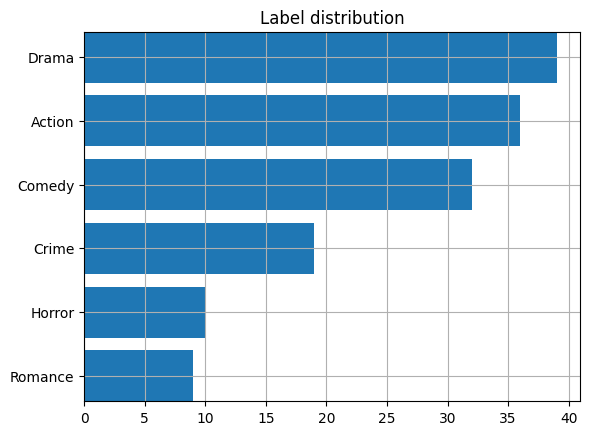

In [25]:
# Calculate label distribution for the entire dataset (train + val)
samples = test_dataset.annos
samples = np.array(samples)
with printoptions(precision=3, suppress=True):
    class_counts = np.sum(samples, axis=0)
    # Sort labels according to their frequency in the dataset.
    sorted_ids = np.array([i[0] for i in sorted(enumerate(class_counts), key=lambda x: x[1])], dtype=int)
    print('Label distribution (count, class name):', list(zip(class_counts[sorted_ids].astype(int), np.array(test_dataset.classes)[sorted_ids])))
    # plt.barh(range(len(dataset_val.classes)), width=class_counts[sorted_ids])
    plt.barh(range(len(test_dataset.classes)), width=class_counts[sorted_ids])
    plt.yticks(range(len(test_dataset.classes)), np.array(test_dataset.classes)[sorted_ids])
    plt.gca().margins(y=0)
    plt.grid()
    plt.title('Label distribution')
    plt.show()

In [26]:
print(len(test_dataset))

146


In [28]:
save_rt_path=cfg['genre_result']['path']
print(save_rt_path)
print(best_acc_epoch)
print(best_loss_epoch)

C:\Users\NGN\dev\automatic_movie_tagging\result\genre
51
3


In [29]:
import numpy
import pandas as pd

# test_model.eval()
model.eval()
start_time = time.time()
name = []
predictions = []
true_data = []
meta_tagger = pd.DataFrame()

fc_name = save_rt_path + '\\' + 'resnet_3_e100.csv'
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    idx = 0
    for inputs, labels, lb_idx in test_dataloader:
        inputs = inputs.to(device)
        lb_idx = lb_idx.to(device)
        # print(f"labels:{labels}")
        # name.append(test_dataloader.dataset.samples[idx])
        outputs=model(inputs)
        # outputs = test_model(inputs)
        # print(f"outputs size:{outputs.size()}") # ([6, 1000])
        # print(f"outputs:{outputs}")
        _, preds = torch.max(outputs, 1) # 입력된 tensor의 dim=1을 기준으로 최댓값 반환
        # print(f"preds:{preds}") # preds:tensor([4, 4, 1, 1, 2, 2], device='cuda:0')
        # loss = criterion(outputs, labels)

        # running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == lb_idx)
        

        class_names=['Action', 'Comedy', 'Crime', 'Drama', 'Horror', 'Romance']
        
        for i in range(len(preds)):
            print(f'filename: {test_dataset.imgs[idx]}, [Prediction]: {class_names[preds[i]]}, (Answer): {class_names[lb_idx[i]]}')
            # 결과 시각화  
            # imshow(inputs.cpu().data[i], title='Prediction: ' + class_names[preds[i]])
            name.append(test_dataset.imgs[idx])
            predictions.append(class_names[preds[i]])
            
            true_data.append(class_names[lb_idx[i]])
            idx+=1

    # epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test Phase] Acc: {:.4f}% Time: {:.4f}s'.format(epoch_acc, time.time() - start_time))
    print(idx)

meta_tagger['title'] = pd.Series(name)
meta_tagger['Prediction Genre'] = pd.Series(predictions)
meta_tagger['Real Genre'] = pd.Series(true_data)
meta_tagger.to_csv(fc_name, encoding='utf-8-sig', index=True)

filename: tt0111257, [Prediction]: Comedy, (Answer): Action
filename: tt0111280, [Prediction]: Comedy, (Answer): Action
filename: tt0111282, [Prediction]: Action, (Answer): Action
filename: tt0111323, [Prediction]: Action, (Answer): Action
filename: tt0111419, [Prediction]: Action, (Answer): Action
filename: tt0111438, [Prediction]: Action, (Answer): Crime
filename: tt0111477, [Prediction]: Comedy, (Answer): Action
filename: tt0111503, [Prediction]: Action, (Answer): Action
filename: tt0111732, [Prediction]: Action, (Answer): Drama
filename: tt0111742, [Prediction]: Horror, (Answer): Drama
filename: tt0111756, [Prediction]: Drama, (Answer): Action
filename: tt0112281, [Prediction]: Comedy, (Answer): Comedy
filename: tt0112302, [Prediction]: Comedy, (Answer): Action
filename: tt0112362, [Prediction]: Drama, (Answer): Romance
filename: tt0112365, [Prediction]: Drama, (Answer): Romance
filename: tt0112384, [Prediction]: Drama, (Answer): Drama
filename: tt0112401, [Prediction]: Comedy, (An